In [17]:
import torch.nn.functional as F

# 快速搭建神经网络

In [18]:
class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden)
        self.predict = torch.nn.Linear(n_hidden, n_output)

    def forward(self, x):
        x = F.relu(self.hidden(x))
        x = self.predict(x)
        return x

net1 = Net(1, 10, 1)   # 这是我们用这种方式搭建的 net1

我们用 class 继承了一个 torch 中的神经网络结构, 然后对其进行了修改, 不过还有更快的一招, 用一句话就概括了上面所有的内容!

In [19]:
net2 = torch.nn.Sequential(
    torch.nn.Linear(1,10),
    torch.nn.ReLU(),
    torch.nn.Linear(10,1)
)

我们再对比一下两者的结构:

In [20]:
print(net1)
"""
Net (
  (hidden): Linear (1 -> 10)
  (predict): Linear (10 -> 1)
)
"""
print(net2)
"""
Sequential (
  (0): Linear (1 -> 10)
  (1): ReLU ()
  (2): Linear (10 -> 1)
)
"""

Net(
  (hidden): Linear(in_features=1, out_features=10, bias=True)
  (predict): Linear(in_features=10, out_features=1, bias=True)
)
Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=1, bias=True)
)


'\nSequential (\n  (0): Linear (1 -> 10)\n  (1): ReLU ()\n  (2): Linear (10 -> 1)\n)\n'

我们会发现 net2 多显示了一些内容, 这是为什么呢? 原来他把激励函数也一同纳入进去了, 但是 net1 中, 激励函数实际上是在 forward() 功能中才被调用的. 这也就说明了, 相比 net2, net1 的好处就是, 你可以根据你的个人需要更加个性化你自己的前向传播过程, 比如(RNN). 不过如果你不需要七七八八的过程, 相信 net2 这种形式更适合你.

# 保存

我们快速地建造数据, 搭建网络:

In [21]:
torch.manual_seed(1)    # reproducible

### 构建数据

In [22]:
# 假数据
x = torch.unsqueeze(torch.linspace(-1, 1, 100), dim=1)  # x data (tensor), shape=(100, 1)
y = x.pow(2) + 0.2*torch.rand(x.size())  # noisy y data (tensor), shape=(100, 1)

x.shape,y.shape

(torch.Size([100, 1]), torch.Size([100, 1]))

In [23]:
def save():
    # 建网络
    net1 = torch.nn.Sequential(
        torch.nn.Linear(1, 10),
        torch.nn.ReLU(),
        torch.nn.Linear(10, 1)
    )
    optimizer = torch.optim.SGD(net1.parameters(), lr=0.5)
    loss_func = torch.nn.MSELoss()
    
    # 训练
    for t in range(100):
        prediction = net1(x)
        loss = loss_func(prediction, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

接下来我们有两种途径来保存

In [24]:
torch.save(net1,'./save/net.pkl')
torch.save(net1.state_dict(),'./save/net_params.pkl')

D:\Anaconda\lib\site-packages\torch\serialization.py:241: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


# 提取网络

这种方式将会提取整个神经网络, 网络大的时候可能会比较慢.

In [25]:
def restore_net():
    # restore entire net1 to net2
    net2 = torch.load('./save/net.pkl')
    prediction = net2(x)

# 只提取网络参数

这种方式将会提取所有的参数, 然后再放到你的新建网络中.

In [30]:
def restore_params():
    # 新建 net3
    net3 = torch.nn.Sequential(
        torch.nn.Linear(1, 10),
        torch.nn.ReLU(),
        torch.nn.Linear(10, 1)
    )

    # 将保存的参数复制到 net3
    net3.load_state_dict(torch.load('./save/net_params.pkl'))
    prediction = net3(x)

# 显示结果

调用上面建立的几个功能, 然后出图.

In [32]:
# 保存 net1 (1. 整个网络, 2. 只有参数)
save()

# 提取整个网络
restore_net()

# 提取网络参数，复制到新网络
# restore_params()

# 批训练

Torch 中提供了一种帮你整理你的数据结构的好东西， 叫做**DataLoader**， 我们能用它来包装自己的数据， 进行批训练。

### DataLoader

DataLoader 是 torch 给你用来包装你的数据的工具. 所以你要讲自己的 (numpy array 或其他) 数据形式装换成 Tensor, 然后再放进这个包装器中. 使用 DataLoader 有什么好处呢? 就是他们帮你有效地迭代数据, 举例:

In [40]:
import torch
import torch.utils.data as Data
from tqdm import tqdm

torch.manual_seed(1)    # reproducible

BATCH_SIZE = 5      # 批训练的数据个数

x = torch.linspace(1, 10, 10)       # x data (torch tensor)
y = torch.linspace(10, 1, 10)       # y data (torch tensor)

x.shape, y.shape

(torch.Size([10]), torch.Size([10]))

In [43]:
# 先转换成 torch 能识别的 Dataset
# 解决报错方案：https://blog.csdn.net/liuhongkai111/article/details/81331155

torch_dataset = Data.TensorDataset(x,y)

# 把 dataset 放入 DataLoader
loader = Data.DataLoader(
    dataset=torch_dataset,      # torch TensorDataset format
    batch_size=BATCH_SIZE,      # mini batch size
    shuffle=True,               # 要不要打乱数据 (打乱比较好)
    num_workers=4,              # 多线程来读数据
)

for epoch in tqdm(range(3)):   # 训练所有!整套!数据 3 次
    for step, (batch_x, batch_y) in enumerate(loader):  # 每一步 loader 释放一小批数据用来学习
        # 假设这里就是你训练的地方...
        # 打出来一些数据
        print('Epoch: ', epoch, '| Step: ', step, '| batch x: ',
              batch_x.numpy(), '| batch y: ', batch_y.numpy())

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

Epoch:  0 | Step:  0 | batch x:  [ 5.  7. 10.  3.  4.] | batch y:  [6. 4. 1. 8. 7.]
Epoch:  0 | Step:  1 | batch x:  [2. 1. 8. 9. 6.] | batch y:  [ 9. 10.  3.  2.  5.]


 33%|████████████████████████████                                                        | 1/3 [00:00<00:01,  1.47it/s]

Epoch:  1 | Step:  0 | batch x:  [ 4.  6.  7. 10.  8.] | batch y:  [7. 5. 4. 1. 3.]
Epoch:  1 | Step:  1 | batch x:  [5. 3. 2. 1. 9.] | batch y:  [ 6.  8.  9. 10.  2.]


 67%|████████████████████████████████████████████████████████                            | 2/3 [00:01<00:00,  1.70it/s]

Epoch:  2 | Step:  0 | batch x:  [ 4.  2.  5.  6. 10.] | batch y:  [7. 9. 6. 5. 1.]
Epoch:  2 | Step:  1 | batch x:  [3. 9. 1. 8. 7.] | batch y:  [ 8.  2. 10.  3.  4.]


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.78it/s]


### 神经网络优化器

# https://morvanzhou.github.io/tutorials/machine-learning/torch/3-06-A-speed-up-learning/
* Stochastic Gradient Descent (SGD)
* Momentum
* AdaGrad
* RMSProp
* Adam

# Optimizer 优化器

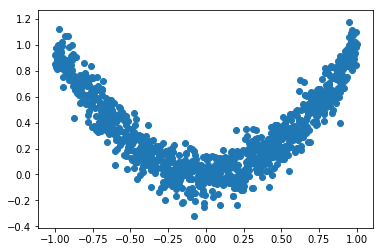

In [44]:
%matplotlib inline

import torch
import torch.utils.data as Data
import torch.nn.functional as F
import matplotlib.pyplot as plt

torch.manual_seed(1)    # reproducible
LR = 0.01
BATCH_SIZE = 32
EPOCH = 12

# fake dataset
x = torch.unsqueeze(torch.linspace(-1, 1, 1000), dim=1)
y = x.pow(2) + 0.1*torch.normal(torch.zeros(*x.size()))

# plot dataset
plt.scatter(x.numpy(), y.numpy())
plt.show()

# 使用上节内容提到的 data loader
torch_dataset = Data.TensorDataset(x, y)
loader = Data.DataLoader(dataset=torch_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2,)

### 每个优化器优化一个神经网络

为了对比每一种优化器, 我们给他们各自创建一个神经网络, 但这个神经网络都来自同一个 Net 形式.

In [45]:
# 默认的 network 形式
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(1, 20)   # hidden layer
        self.predict = torch.nn.Linear(20, 1)   # output layer

    def forward(self, x):
        x = F.relu(self.hidden(x))      # activation function for hidden layer
        x = self.predict(x)             # linear output
        return x

# 为每个优化器创建一个 net
net_SGD = Net()
net_Momentum = Net()
net_RMSprop = Net()
net_Adam = Net()
nets = [net_SGD, net_Momentum, net_RMSprop, net_Adam]

# 优化器 Optimizer 

接下来在创建不同的优化器, 用来训练不同的网络. 并创建一个 loss_func 用来计算误差. 我们用几种常见的优化器, **SGD**, **Momentum**, **RMSprop**, **Adam**.

In [47]:
# different optimizers
opt_SGD = torch.optim.SGD(net_SGD.parameters(), lr=LR)
opt_Momentum = torch.optim.SGD(net_Momentum.parameters(), lr=LR, momentum=0.8)
opt_RMSprop = torch.optim.RMSprop(net_RMSprop.parameters(), lr=LR, alpha=0.9)
opt_Adam = torch.optim.Adam(net_Adam.parameters(), lr=LR, betas=(0.9, 0.99))
optimizers = [opt_SGD, opt_Momentum, opt_RMSprop, opt_Adam]

loss_func = torch.nn.MSELoss()
losses_his = [[], [], [], []]   # 记录 training 时不同神经网络的 loss

# 训练/出图 

接下来训练和 loss 画图.

In [50]:
%matplotlib inline

for epoch in range(EPOCH):
    print('Epoch: ', epoch)
    for step, (b_x, b_y) in enumerate(loader):
        # 对每个优化器, 优化属于他的神经网络
        for net, opt, l_his in zip(nets, optimizers, losses_his):
            output = net(b_x)              # get output for every net
            loss = loss_func(output, b_y)  # compute loss for every net
            opt.zero_grad()                # clear gradients for next train
            loss.backward()                # backpropagation, compute gradients
            opt.step()                     # apply gradients
            l_his.append(loss.data.numpy())     # loss recoder

Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
Epoch:  10
Epoch:  11


SGD 是最普通的优化器, 也可以说没有加速效果, 而 Momentum 是 SGD 的改良版, 它加入了动量原则. 后面的 RMSprop 又是 Momentum 的升级版. 而 Adam 又是 RMSprop 的升级版. 不过从这个结果中我们看到, Adam 的效果似乎比 RMSprop 要差一点. 所以说并不是越先进的优化器, 结果越佳. 我们在自己的试验中可以尝试不同的优化器, 找到那个最适合你数据/网络的优化器.

### 整体代码如下

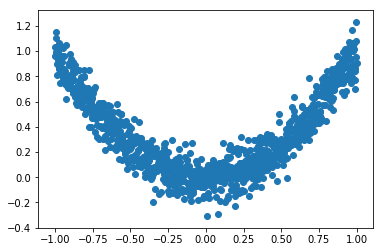

Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
Epoch:  10
Epoch:  11


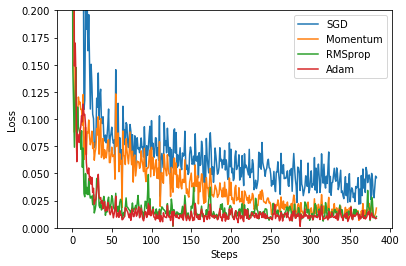

In [51]:
import torch
import torch.utils.data as Data
import torch.nn.functional as F
import matplotlib.pyplot as plt

# torch.manual_seed(1)    # reproducible

LR = 0.01
BATCH_SIZE = 32
EPOCH = 12

# fake dataset
x = torch.unsqueeze(torch.linspace(-1, 1, 1000), dim=1)
y = x.pow(2) + 0.1*torch.normal(torch.zeros(*x.size()))

# plot dataset
plt.scatter(x.numpy(), y.numpy())
plt.show()

# put dateset into torch dataset
torch_dataset = Data.TensorDataset(x, y)
loader = Data.DataLoader(dataset=torch_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2,)


# default network
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(1, 20)   # hidden layer
        self.predict = torch.nn.Linear(20, 1)   # output layer

    def forward(self, x):
        x = F.relu(self.hidden(x))      # activation function for hidden layer
        x = self.predict(x)             # linear output
        return x

if __name__ == '__main__':
    # different nets
    net_SGD         = Net()
    net_Momentum    = Net()
    net_RMSprop     = Net()
    net_Adam        = Net()
    nets = [net_SGD, net_Momentum, net_RMSprop, net_Adam]

    # different optimizers
    opt_SGD         = torch.optim.SGD(net_SGD.parameters(), lr=LR)
    opt_Momentum    = torch.optim.SGD(net_Momentum.parameters(), lr=LR, momentum=0.8)
    opt_RMSprop     = torch.optim.RMSprop(net_RMSprop.parameters(), lr=LR, alpha=0.9)
    opt_Adam        = torch.optim.Adam(net_Adam.parameters(), lr=LR, betas=(0.9, 0.99))
    optimizers = [opt_SGD, opt_Momentum, opt_RMSprop, opt_Adam]

    loss_func = torch.nn.MSELoss()
    losses_his = [[], [], [], []]   # record loss

    # training
    for epoch in range(EPOCH):
        print('Epoch: ', epoch)
        for step, (b_x, b_y) in enumerate(loader):          # for each training step
            for net, opt, l_his in zip(nets, optimizers, losses_his):
                output = net(b_x)              # get output for every net
                loss = loss_func(output, b_y)  # compute loss for every net
                opt.zero_grad()                # clear gradients for next train
                loss.backward()                # backpropagation, compute gradients
                opt.step()                     # apply gradients
                l_his.append(loss.data.numpy())     # loss recoder

    labels = ['SGD', 'Momentum', 'RMSprop', 'Adam']
    for i, l_his in enumerate(losses_his):
        plt.plot(l_his, label=labels[i])
    plt.legend(loc='best')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.ylim((0, 0.2))
    plt.show()